In [1]:
import sys
import os
%load_ext autoreload
%autoreload 2
import pylab as plt
%matplotlib inline

In [2]:
mzml_folder = '/Users/simon/TempStuff/lipid_files/centroid/'
mzml_file = os.path.join(mzml_folder,'8_pp_d20_pos_1.mzML')

In [3]:
sys.path.append('/Users/simon/git/pymzm')
sys.path.append('/Users/simon/git/mass-spec-utils')
from Roi import make_roi
mz_units = 'ppm'
mz_tol = 10
min_length = 5
min_intensity = 1e3
max_gap_run = 1
good,junk = make_roi(mzml_file,
                     mz_tol = mz_tol,
                     mz_units = mz_units,
                     min_length = min_length,
                     min_intensity = min_intensity,
                     max_gap_run = max_gap_run)
print(len(good))

19546


In [4]:
good.sort()

In [37]:
from molmass import Formula
from Roi import roi_correlation
from adduct_rules import AdductTransformer
at = AdductTransformer()
ion_mode = 'Pos'
lipids = {'PC 34:1':('C42H82NO8P','C42H81DNO8P',760.5836,10.47*60,'[M+H]+'),
          'PC 34:2':('C42H80NO8P','C42H79DNO8P',758.5677,9.78*60.0,'[M+H]+'),
          'PC 34:0':('C42H84NO8P','C42H83DNO8P',762.5997,11.2*60.0,'[M+H]+'),
          'PC 34:0p':('C42H84NO7P','C42H83DNO7P',746.8044,11.03*60.0,'[M+H]+'),
          'PC 38:5p':('C43H76NO7P','C43H75DNO7P',750.5421,10.63*60.0,'[M+H]+'),
          'PC 38:4p':('C43H78NO7P','C43H77DNO7P',752.5577,11.3*60.0,'[M+H]+'),
         }
for lipid,dets in lipids.items():
    if not lipid == 'PC 34:0':
        continue
    print(lipid,dets)
    f = Formula(dets[0])
#     print("Mono: ",f.isotope.mass)
    if ion_mode == 'Pos':
        mz = at.mass2ion(f.isotope.mass,dets[4])
    rt = dets[3]
#     print(mz,rt)
    ppm = 10
    tol = ppm*mz/1e6
    candidate_rois = list(filter(lambda x: x.get_mean_mz() >= mz - tol and x.get_mean_mz() <= mz + tol,good))
    candidate_rois.sort(key = lambda x: x.get_max_intensity(),reverse = True)
    
    # for each candidate, find any that correlate well and have isotopic mz/shift (i.e multiple of proton)
    correlators = {}
    max_iso_num = 10
    PROTON_MASS = 1.00727645199076
    thresh = 0.6
    for roi in candidate_rois:
        correlators[roi] = []
        for g in good:
            if g == roi:
                continue
            if g.get_mean_mz() < roi.get_mean_mz():
                continue
            found = False
            for i in range(1,max_iso_num+1):
                cand_mz = roi.get_mean_mz() + i*PROTON_MASS
                tol = 20*cand_mz/1e6
                if g.get_mean_mz() >= cand_mz - tol and g.get_mean_mz() <= cand_mz + tol:
                    found = True
                    break
            if not found:
                continue
            corr = roi_correlation(roi,g)
            if corr >= thresh:
                correlators[roi].append(g)
    sizes = []
    for roi in candidate_rois:
        print('\t',mz,roi.get_mean_mz(),roi.get_apex_rt(),len(correlators[roi]))
    

PC 34:0 ('C42H84NO8P', 'C42H83DNO8P', 762.5997, 672.0, '[M+H]+')
	 762.6007321188208 762.5990219011802 670.2 3
	 762.6007321188208 762.5998750076055 463.0902 1
	 762.6007321188208 762.5994964617183 540.6677999999999 1
	 762.6007321188208 762.6068163438197 899.496 0
	 762.6007321188208 762.5998091965097 488.6742 1
	 762.6007321188208 762.5998067301695 473.8188 0
	 762.6007321188208 762.6001461911122 523.3362 0
	 762.6007321188208 762.5996679546116 510.13079999999997 0


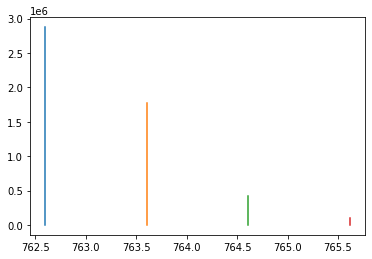

In [38]:
roi = candidate_rois[0]
plt.figure()
plt.plot([roi.get_mean_mz(),roi.get_mean_mz()],[0,roi.get_max_intensity()])
for g in correlators[roi]:
    plt.plot([g.get_mean_mz(),g.get_mean_mz()],[0,g.get_max_intensity()])

In [28]:
for g in correlators[roi]:
    print(g)

ROI with data points=43 mz (747.6091-747.6090) rt (650.6760-684.9360)
ROI with data points=34 mz (748.6110-748.6110) rt (653.9340-680.8320)
ROI with data points=22 mz (749.6116-749.6150) rt (655.5660-673.4700)
ROI with data points=8 mz (750.6280-750.6281) rt (657.1980-662.8800)


In [29]:
gg = list(filter(lambda x: x.get_mean_mz() > 748.5 and x.get_mean_mz() < 748.62,good))
for g in gg:
    print(g)
g = gg[-1]
roi_correlation(roi,g)

ROI with data points=12 mz (748.5113-748.5111) rt (563.7408-575.1342)
ROI with data points=21 mz (748.5119-748.5120) rt (539.8422-557.1738)
ROI with data points=12 mz (748.5190-748.5189) rt (523.3362-532.4142)
ROI with data points=15 mz (748.5250-748.5286) rt (615.0000-626.3580)
ROI with data points=14 mz (748.5363-748.5363) rt (343.4232-354.9768)
ROI with data points=5 mz (748.5396-748.5431) rt (1305.5400-1310.4960)
ROI with data points=15 mz (748.5399-748.5399) rt (198.1770-212.2068)
ROI with data points=62 mz (748.5501-748.5501) rt (369.8328-421.0002)
ROI with data points=67 mz (748.5499-748.5466) rt (437.5056-497.7516)
ROI with data points=9 mz (748.5497-748.5499) rt (511.7814-519.2100)
ROI with data points=14 mz (748.5501-748.5466) rt (423.4758-434.2044)
ROI with data points=5 mz (748.5501-748.5501) rt (359.1036-362.4054)
ROI with data points=10 mz (748.5765-748.5736) rt (685.7640-694.0140)
ROI with data points=32 mz (748.5767-748.5766) rt (588.9492-614.1900)
ROI with data points=

0.9976721436340907